<a href="https://colab.research.google.com/github/LingfangLi/Fine-tune-contrastive-method-model/blob/main/Copy_of_Interpreting_LM_with_Contrastive_Explanations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Interpreting Language Models with Contrastive Explanations
### ___Kayo Yin and Graham Neubig___
This Colab notebook lets you visualize contrastive explanations for language model decisions, based on [Yin and Neubig (2022)](https://arxiv.org/abs/2202.10419).





In [ ]:
#@title #**Setup Environment**
#@markdown Install and import Python dependencies.
print('Installing dependencies...')
!pip3 install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
!pip install transformers
!git clone https://github.com/kayoyin/interpret-lm.git &> /dev/null

print('Importing libraries...')
import sys
sys.path.append('./interpret-lm')
from lm_saliency import *

print('Done!')

if not torch.cuda.is_available():
  print("Please restart runtime with GPU")

Installing dependencies...
Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu113
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 18.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 35.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 57.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 59.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 29.0 MB/s eta 0:00:00
Importing libraries...


Done!


In [ ]:
#@markdown #**Load Language Model**
model_name = "gpt-2" #@param ["gpt-2", "gpt-neo"]

if model_name == "gpt-2":
  tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
  model = GPT2LMHeadModel.from_pretrained("gpt2")
elif model_name == "gpt-neo":
  model = GPTNeoForCausalLM.from_pretrained("EleutherAI/gpt-neo-1.3B")
  tokenizer = GPT2Tokenizer.from_pretrained("EleutherAI/gpt-neo-1.3B")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
assert device.type == "cuda"
model.to(device)

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [ ]:
#@markdown #**Define Input**
input = "Would you like to eat" #@param {type:"string"}
input = input.strip() + " "
input_tokens = tokenizer(input)['input_ids']
attention_ids = tokenizer(input)['attention_mask']

preds = model_preds(model, [input_tokens], [attention_ids], -1, tokenizer, foils=None, k=10, verbose=True)

Top model predictions:
0.166:  see
0.046:  know
0.042:  be
0.03:  read
0.029:  play
0.028:  join
0.028:  learn
0.025:  hear
0.025:  watch
0.021:  go


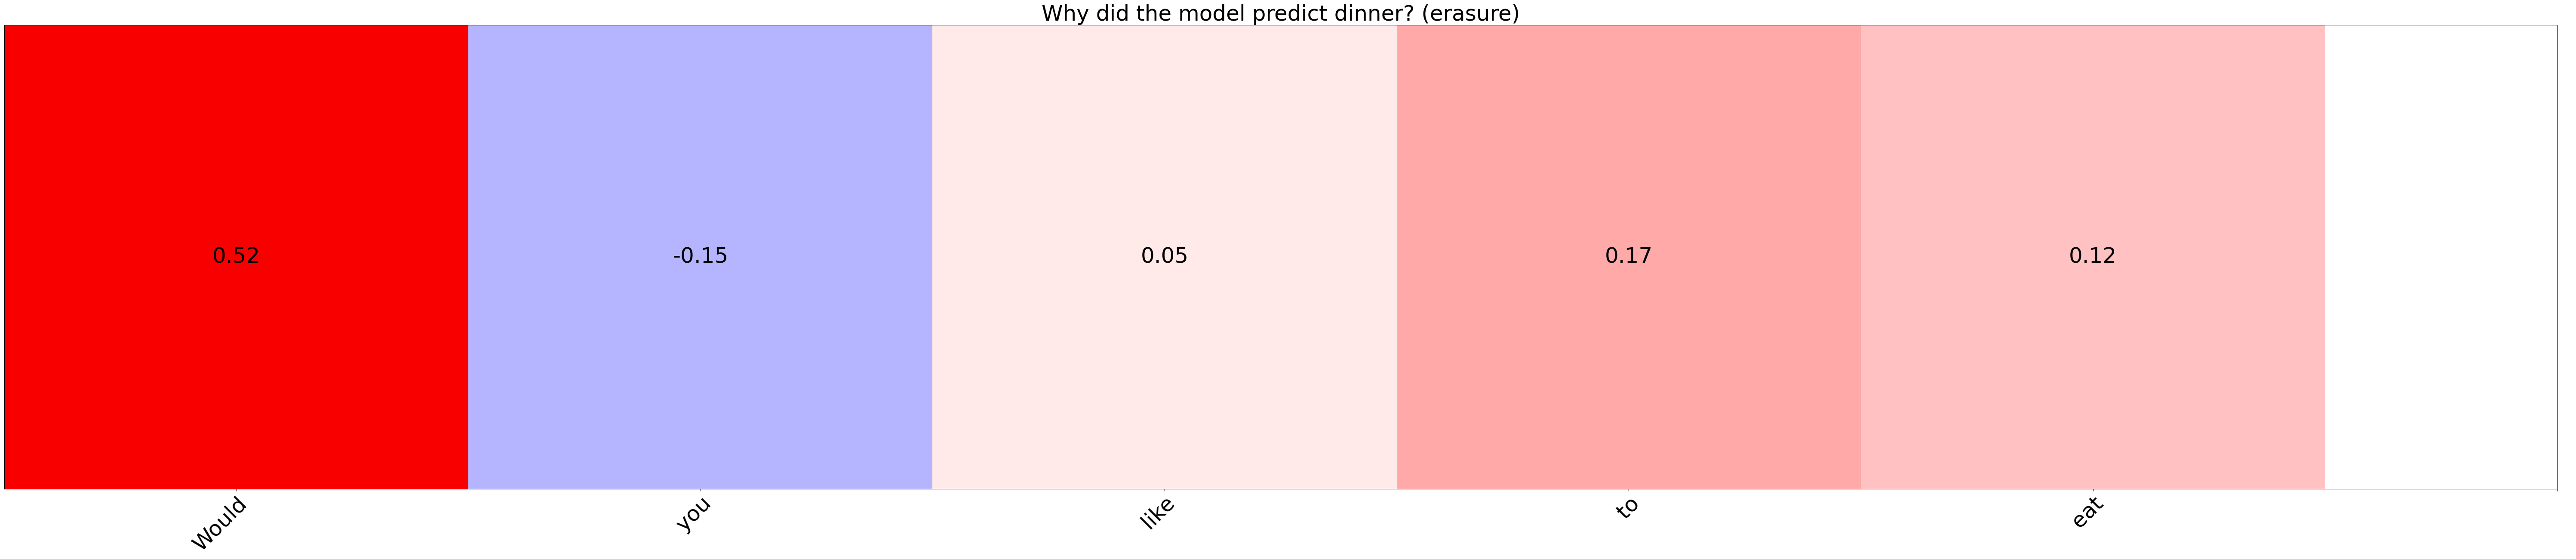

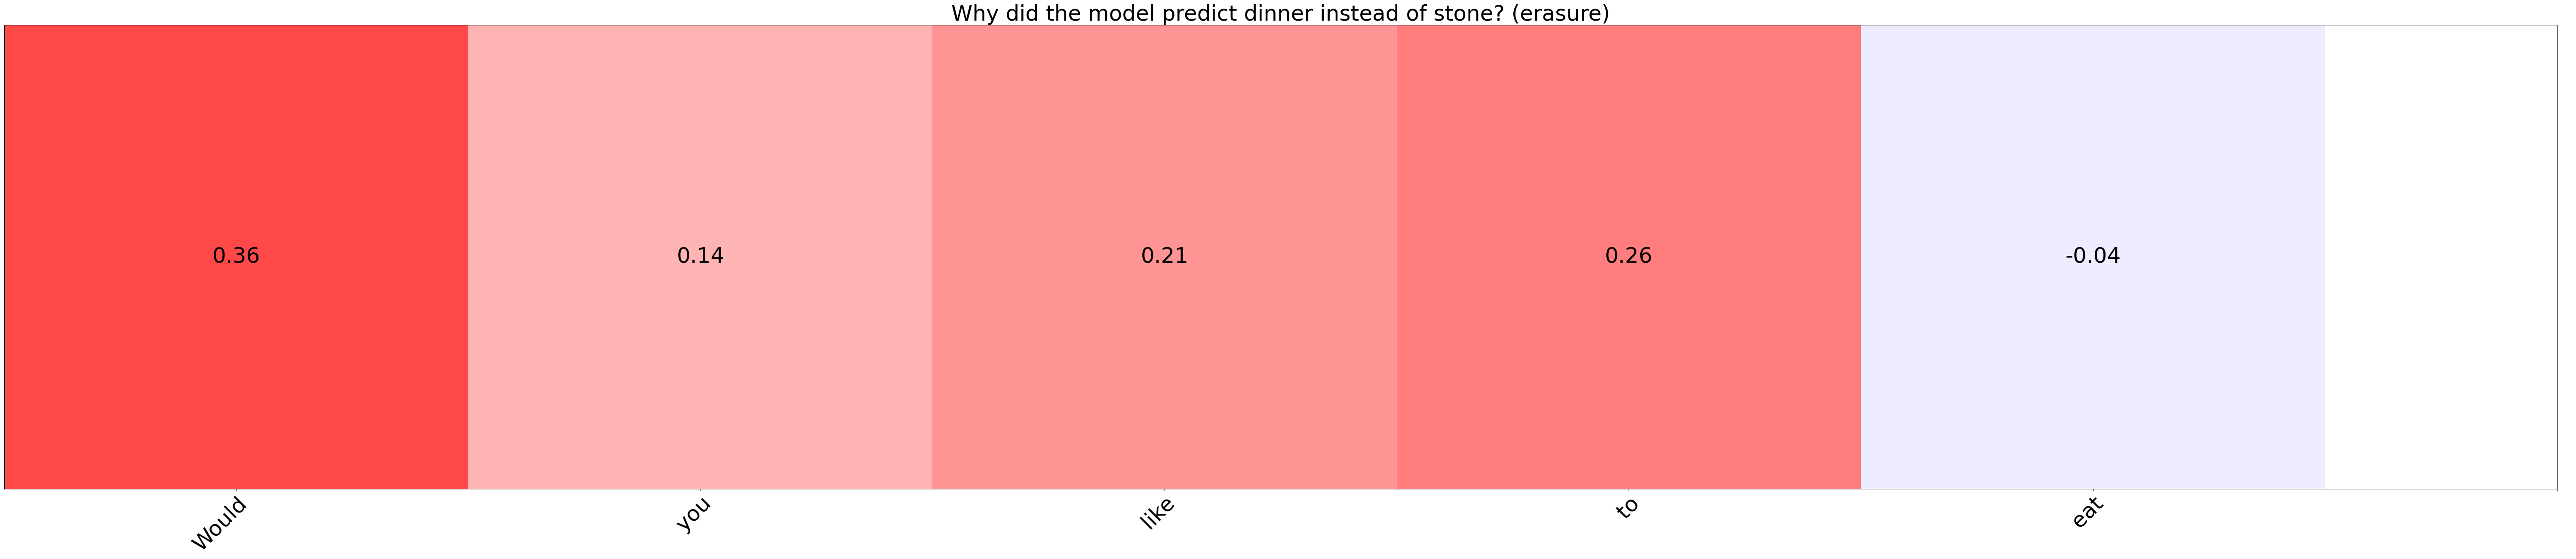

In [ ]:
#@markdown #**Visualize Explanations**
target = "dinner" #@param {type:"string"}
foil = "stone" #@param {type:"string"}
explanation = "erasure" #@param ["input x gradient", "gradient norm", "erasure"]

CORRECT_ID = tokenizer(" "+ target)['input_ids'][0]
FOIL_ID = tokenizer(" "+ foil)['input_ids'][0]

if explanation == "erasure":
  base_explanation = erasure_scores(model, input_tokens, attention_ids, normalize=True)
  contra_explanation = erasure_scores(model, input_tokens, attention_ids, correct=CORRECT_ID, foil=FOIL_ID, normalize=True)
else:
  base_saliency_matrix, base_embd_matrix = saliency(model, input_tokens, attention_ids)
  saliency_matrix, embd_matrix = saliency(model, input_tokens, attention_ids, foil=FOIL_ID)
  if explanation == "input x gradient":
    base_explanation = input_x_gradient(base_saliency_matrix, base_embd_matrix, normalize=True)
    contra_explanation = input_x_gradient(saliency_matrix, embd_matrix, normalize=True)
  elif explanation == "gradient norm":
    base_explanation = l1_grad_norm(base_saliency_matrix, normalize=True)
    contra_explanation = l1_grad_norm(saliency_matrix, normalize=True)

visualize(np.array(base_explanation), tokenizer, [input_tokens], print_text=True, title=f"Why did the model predict {target}? ({explanation})")
visualize(np.array(contra_explanation), tokenizer, [input_tokens], print_text=True, title=f"Why did the model predict {target} instead of {foil}? ({explanation})")

